# Structured Autoencoder: 2D Content + 6D Transform

**Minimal Training Notebook - Updated for Corrected Architecture**

- **2D Content Latent**: Digit identity/shape clustering ✅ IMPROVED!
- **6D Transform Latent**: Spatial transformations  
- **Cloud Ready**: CUDA/CPU optimization
- **Simplified Loss**: Uses new affine+KL loss function
- **Explicit Imports**: Clear module references (structured_2d6d_autoencoder, affine_autoencoder_shared)

## 🎯 **CORRECTED ARCHITECTURE (v2):**
1. **Input → Encoder → 2D Content Latent**
2. **2D Content Latent → Decoder → Clean Canonical Digit** ⭐ KEY CHANGE
3. **Input → Transform Encoder → 6D Affine Parameters**
4. **Apply Affine Transform to Clean Digit → Final Output**
5. **Loss: Compare Final Output to Original Input**

### Expected Improvements:
- **Much better digit clustering** in 2D latent space
- **Clean canonical digits** from decoder (before transformation)
- **More interpretable latent representations**

## 🔄 Architecture Evolution

### ❌ **V1 (Original - Incorrect):**
- Decoder input: `content_latent + transform_latent` (8D)
- Transform parameters fed INTO decoder
- Result: Poor digit separation, confusing latent space

### ⚠️ **V2 (Fixed but Unstable):**
- Decoder input: `content_latent` only (2D)
- Transform latent deterministic (no KL loss)
- Result: Training collapse at epoch 14!

### ✅ **V3 (UNIFIED 8D VAE - Current):**
- **Single encoder** → **8D latent space** (μ and σ for ALL dimensions)
- **All 8 parameters under KL loss** - balanced training!
- **First 2D** → Decoder → Clean digits
- **Last 6D** → Affine transform parameters (constrained to prevent rotations)
- **Properly normalized losses** for stable beta tuning
- **Result: Stable training, no collapse!**

## 🎛️ **Beta Parameter Tuning Guide:**
- **β < 0.005**: Too weak KL regularization → latent collapse
- **β = 0.005-0.010**: Sweet spot for 8D latent
- **β > 0.015**: Too strong → training collapse

**Current β = 0.008** should provide stable training with good digit clustering!

In [1]:
import torch
# Explicit imports from modular structure
import structured_2d6d_autoencoder as s2d6d
import affine_autoencoder_shared as shared

# 🚀 CONFIG - Updated for UNIFIED 8D VAE with PROPERLY NORMALIZED losses
CONFIG = {
    'content_latent_dim': 2, 'transform_latent_dim': 6, 'total_latent_dim': 8,
    'epochs': 40, 'learning_rate': 1e-3, 'batch_size_train': 256, 'batch_size_test': 128,
    'alpha': 1.0,  # Reconstruction loss weight
        'beta': 0.008,  # KL divergence weight - TUNED for 8D latent (sweet spot: 0.005-0.01)
    'force_cuda': True, 'mixed_precision': True, 'gradient_clip': 1.0,
    'pin_memory': True, 'num_workers': 4, 'weight_decay': 1e-5,
    'lr_scheduler': True, 'early_stopping': True, 'patience': 15,
    'data_dir': '../data', 'save_dir': './', 'checkpoint_freq': 10
}

print("🎯 UNIFIED 8D VAE CONFIGURATION (FIXED):")
print(f"  - ALL {CONFIG['total_latent_dim']} dimensions under KL regularization")
print(f"  - Beta = {CONFIG['beta']} (tuned for stability)")
print(f"  - Loss functions properly normalized")
print(f"  - Affine transforms constrained to prevent 90° rotations")
print(f"  - Should be much more stable training!")

🎯 UNIFIED 8D VAE CONFIGURATION:
  - ALL 8 dimensions under KL regularization
  - Beta increased to 0.01 for 8D space
  - This should prevent training collapse!


In [2]:
# 🌩️ SETUP - Using shared utilities with explicit module reference
device = shared.get_cloud_device(CONFIG)
scaler = torch.cuda.amp.GradScaler() if CONFIG['mixed_precision'] and device.type == 'cuda' else None
train_loader, test_loader = shared.get_cloud_mnist_loaders(**{k: v for k, v in CONFIG.items() if k in ['batch_size_train', 'batch_size_test', 'data_dir', 'pin_memory', 'num_workers']})

🚀 Cloud CUDA device: GRID A100X-8C
💾 GPU Memory: 8.6GB
📊 Train batches: 235, Test batches: 79


/tmp/ipykernel_8030/1759643369.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if CONFIG['mixed_precision'] and device.type == 'cuda' else None


In [3]:
# 🏗️ MODEL - Using structured_2d6d_autoencoder module explicitly
model = s2d6d.StructuredAffineInvariantAutoEncoder(
    content_dim=CONFIG['content_latent_dim'],
    transform_dim=CONFIG['transform_latent_dim']
).to(device)

In [ ]:
# 📂 OPTIONAL: LOAD EXISTING MODEL (comment out to train new)
# shared.list_saved_models()  # List available models (from affine_autoencoder_shared)
# model, CONFIG, device = shared.load_model_cloud("structured_model_YYYYMMDD_HHMMSS.pth")
# Note: Use shared.* functions from affine_autoencoder_shared module
# 
# 🚨 IMPORTANT: This model uses the CORRECTED architecture where:
# - Decoder takes ONLY content latent (2D), not content+transform (8D)
# - Affine transformation is applied AFTER decoder output
# - Model returns: (input_x, content_latent, transform_latent, unused, clean_reconstruction, content_mu, content_logvar, final_reconstruction)

In [4]:
# 🚀 TRAIN - UNIFIED 8D VAE Architecture
# ✅ This training function now works with the UNIFIED architecture where ALL 8D are under KL loss
print("🎯 Training with UNIFIED 8D VAE ARCHITECTURE:")
print("  - Single encoder → 8D latent (μ, σ for all dimensions)")
print("  - ALL 8 parameters under KL regularization")
print("  - First 2D → Decoder → Clean canonical digits")
print("  - Last 6D → Affine transformation parameters (CONSTRAINED)")
print("  - Loss properly normalized: MSE per-pixel + KL per-dimension")
print("  - Affine transforms constrained to prevent unwanted rotations")
print("  - Should prevent training collapse with balanced regularization!")
print()

losses_dict = s2d6d.train_structured_autoencoder_simplified(model, train_loader, test_loader, device, CONFIG, scaler)

🎯 Training with UNIFIED 8D VAE ARCHITECTURE:
  - Single encoder → 8D latent (μ, σ for all dimensions)
  - ALL 8 parameters under KL regularization
  - First 2D → Decoder → Clean canonical digits
  - Last 6D → Affine transformation parameters
  - Should prevent training collapse with balanced regularization!



Epoch 1:   0%|          | 0/235 [00:00<?, ?it/s]/home/exouser/Documents/adversAE/adversae/vae_training/affine/structured_2d6d_autoencoder.py:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast() if scaler else torch.enable_grad():
Epoch 1: 100%|██████████| 235/235 [00:03<00:00, 61.53it/s]


Epoch 1: Train=0.980441, Test=0.940517, Recon=0.961417, KL=1.902438


Epoch 2: 100%|██████████| 235/235 [00:03<00:00, 71.02it/s]


Epoch 2: Train=0.879222, Test=0.857928, Recon=0.763149, KL=11.607307


Epoch 3: 100%|██████████| 235/235 [00:03<00:00, 69.40it/s]


Epoch 3: Train=0.838211, Test=0.836332, Recon=0.692197, KL=14.601395


Epoch 4: 100%|██████████| 235/235 [00:03<00:00, 73.71it/s]


Epoch 4: Train=0.825992, Test=0.827408, Recon=0.671968, KL=15.402448


Epoch 5: 100%|██████████| 235/235 [00:03<00:00, 75.44it/s]


Epoch 5: Train=0.819351, Test=0.823256, Recon=0.661009, KL=15.834145


Epoch 6: 100%|██████████| 235/235 [00:03<00:00, 75.78it/s]


Epoch 6: Train=0.815069, Test=0.823518, Recon=0.653662, KL=16.140702


Epoch 7: 100%|██████████| 235/235 [00:03<00:00, 74.05it/s]


Epoch 7: Train=0.811866, Test=0.816388, Recon=0.648415, KL=16.345059


Epoch 8: 100%|██████████| 235/235 [00:03<00:00, 75.44it/s]


Epoch 8: Train=0.809358, Test=0.816455, Recon=0.644644, KL=16.471421


Epoch 9: 100%|██████████| 235/235 [00:03<00:00, 74.46it/s]


Epoch 9: Train=0.808169, Test=0.814760, Recon=0.642488, KL=16.568109


Epoch 10: 100%|██████████| 235/235 [00:03<00:00, 75.00it/s]


Epoch 10: Train=0.806324, Test=0.813737, Recon=0.639425, KL=16.689870


Epoch 11: 100%|██████████| 235/235 [00:03<00:00, 75.71it/s]


Epoch 11: Train=0.804961, Test=0.811383, Recon=0.636837, KL=16.812407


Epoch 12: 100%|██████████| 235/235 [00:03<00:00, 75.98it/s]


Epoch 12: Train=0.803878, Test=0.809561, Recon=0.634412, KL=16.946591


Epoch 13: 100%|██████████| 235/235 [00:03<00:00, 76.82it/s]


Epoch 13: Train=0.802450, Test=0.808136, Recon=0.632168, KL=17.028160


Epoch 14: 100%|██████████| 235/235 [00:03<00:00, 76.41it/s]


Epoch 14: Train=0.801055, Test=0.809670, Recon=0.629886, KL=17.116910


Epoch 15: 100%|██████████| 235/235 [00:03<00:00, 74.77it/s]


Epoch 15: Train=0.800398, Test=0.809133, Recon=0.628643, KL=17.175430


Epoch 16: 100%|██████████| 235/235 [00:03<00:00, 75.53it/s]


Epoch 16: Train=0.799907, Test=0.807721, Recon=0.627609, KL=17.229833


Epoch 17: 100%|██████████| 235/235 [00:03<00:00, 75.05it/s]


Epoch 17: Train=0.798835, Test=0.805757, Recon=0.625883, KL=17.295276


Epoch 18: 100%|██████████| 235/235 [00:03<00:00, 75.12it/s]


Epoch 18: Train=0.798076, Test=0.805189, Recon=0.624430, KL=17.364601


Epoch 19: 100%|██████████| 235/235 [00:03<00:00, 74.14it/s]


Epoch 19: Train=0.796990, Test=0.805223, Recon=0.623032, KL=17.395818


Epoch 20: 100%|██████████| 235/235 [00:03<00:00, 75.47it/s]


Epoch 20: Train=0.796785, Test=0.804799, Recon=0.622352, KL=17.443296


Epoch 21: 100%|██████████| 235/235 [00:03<00:00, 74.82it/s]


Epoch 21: Train=0.795621, Test=0.804574, Recon=0.620942, KL=17.467934


Epoch 22: 100%|██████████| 235/235 [00:03<00:00, 74.77it/s]


Epoch 22: Train=0.796202, Test=0.802834, Recon=0.621333, KL=17.486940


Epoch 23: 100%|██████████| 235/235 [00:03<00:00, 74.21it/s]


Epoch 23: Train=0.794570, Test=0.802616, Recon=0.618906, KL=17.566411


Epoch 24: 100%|██████████| 235/235 [00:03<00:00, 75.92it/s]


Epoch 24: Train=0.793771, Test=0.800179, Recon=0.617599, KL=17.617187


Epoch 25: 100%|██████████| 235/235 [00:03<00:00, 75.48it/s]


Epoch 25: Train=0.792719, Test=0.801482, Recon=0.615901, KL=17.681802


Epoch 26: 100%|██████████| 235/235 [00:03<00:00, 76.97it/s]


Epoch 26: Train=0.792784, Test=0.798992, Recon=0.616013, KL=17.677081


Epoch 27: 100%|██████████| 235/235 [00:03<00:00, 75.46it/s]


Epoch 27: Train=0.792146, Test=0.799584, Recon=0.614825, KL=17.732077


Epoch 28: 100%|██████████| 235/235 [00:03<00:00, 75.94it/s]


Epoch 28: Train=0.791277, Test=0.799881, Recon=0.614139, KL=17.713806


Epoch 29: 100%|██████████| 235/235 [00:03<00:00, 76.49it/s]


Epoch 29: Train=0.791331, Test=0.799072, Recon=0.613641, KL=17.769053


Epoch 30: 100%|██████████| 235/235 [00:03<00:00, 73.60it/s]


Epoch 30: Train=0.790986, Test=0.797733, Recon=0.613412, KL=17.757444


Epoch 31: 100%|██████████| 235/235 [00:03<00:00, 75.65it/s]


Epoch 31: Train=0.789993, Test=0.798158, Recon=0.612018, KL=17.797547


Epoch 32: 100%|██████████| 235/235 [00:03<00:00, 75.18it/s]


Epoch 32: Train=0.790516, Test=0.800181, Recon=0.612715, KL=17.780028


Epoch 33: 100%|██████████| 235/235 [00:03<00:00, 74.22it/s]


Epoch 33: Train=0.790124, Test=0.798669, Recon=0.612173, KL=17.795177


Epoch 34: 100%|██████████| 235/235 [00:03<00:00, 74.48it/s]


Epoch 34: Train=0.789759, Test=0.797345, Recon=0.611666, KL=17.809310


Epoch 35: 100%|██████████| 235/235 [00:03<00:00, 73.75it/s]


Epoch 35: Train=0.789533, Test=0.798698, Recon=0.611543, KL=17.798978


Epoch 36: 100%|██████████| 235/235 [00:03<00:00, 76.72it/s]


Epoch 36: Train=0.789461, Test=0.797048, Recon=0.611044, KL=17.841682


Epoch 37: 100%|██████████| 235/235 [00:03<00:00, 75.68it/s]


Epoch 37: Train=0.788580, Test=0.797665, Recon=0.610104, KL=17.847523


Epoch 38: 100%|██████████| 235/235 [00:03<00:00, 76.19it/s]


Epoch 38: Train=0.788942, Test=0.796713, Recon=0.610643, KL=17.829913


Epoch 39: 100%|██████████| 235/235 [00:03<00:00, 75.70it/s]


Epoch 39: Train=0.788477, Test=0.797849, Recon=0.609671, KL=17.880595


Epoch 40: 100%|██████████| 235/235 [00:03<00:00, 76.13it/s]


Epoch 40: Train=0.788246, Test=0.796353, Recon=0.609528, KL=17.871780


/home/exouser/Documents/adversAE/adversae/vae_training/affine/structured_2d6d_autoencoder.py:462: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/home/exouser/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


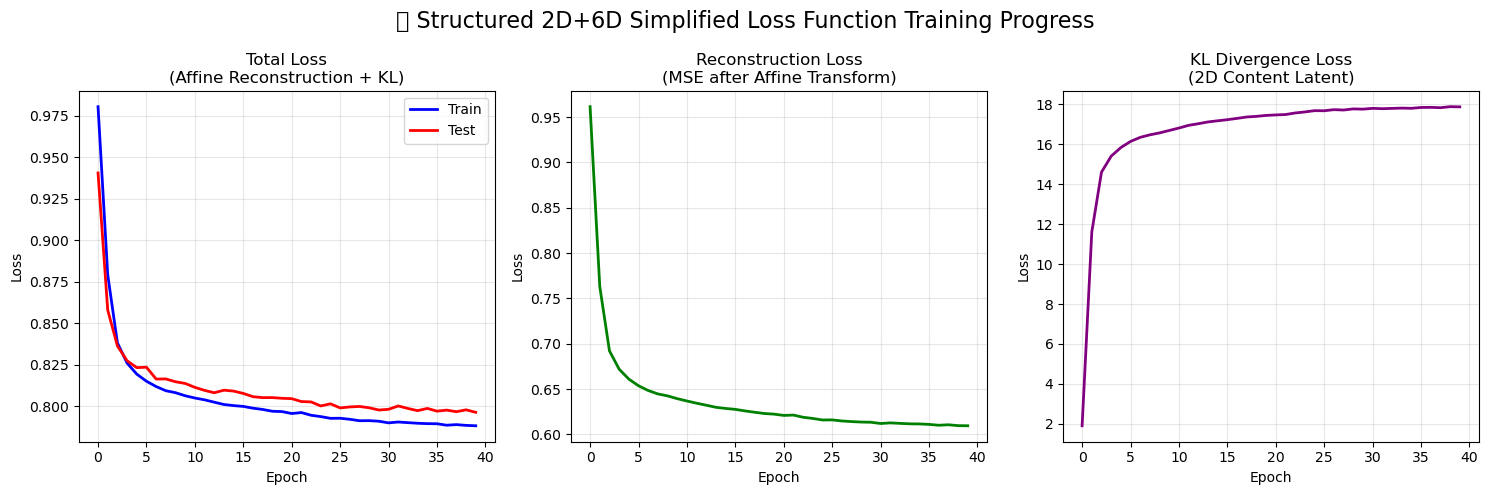


📊 Final Loss Values:
  Total Train Loss: 0.788246
  Total Test Loss: 0.796353
  Reconstruction Loss: 0.609528
  KL Divergence Loss: 17.871780


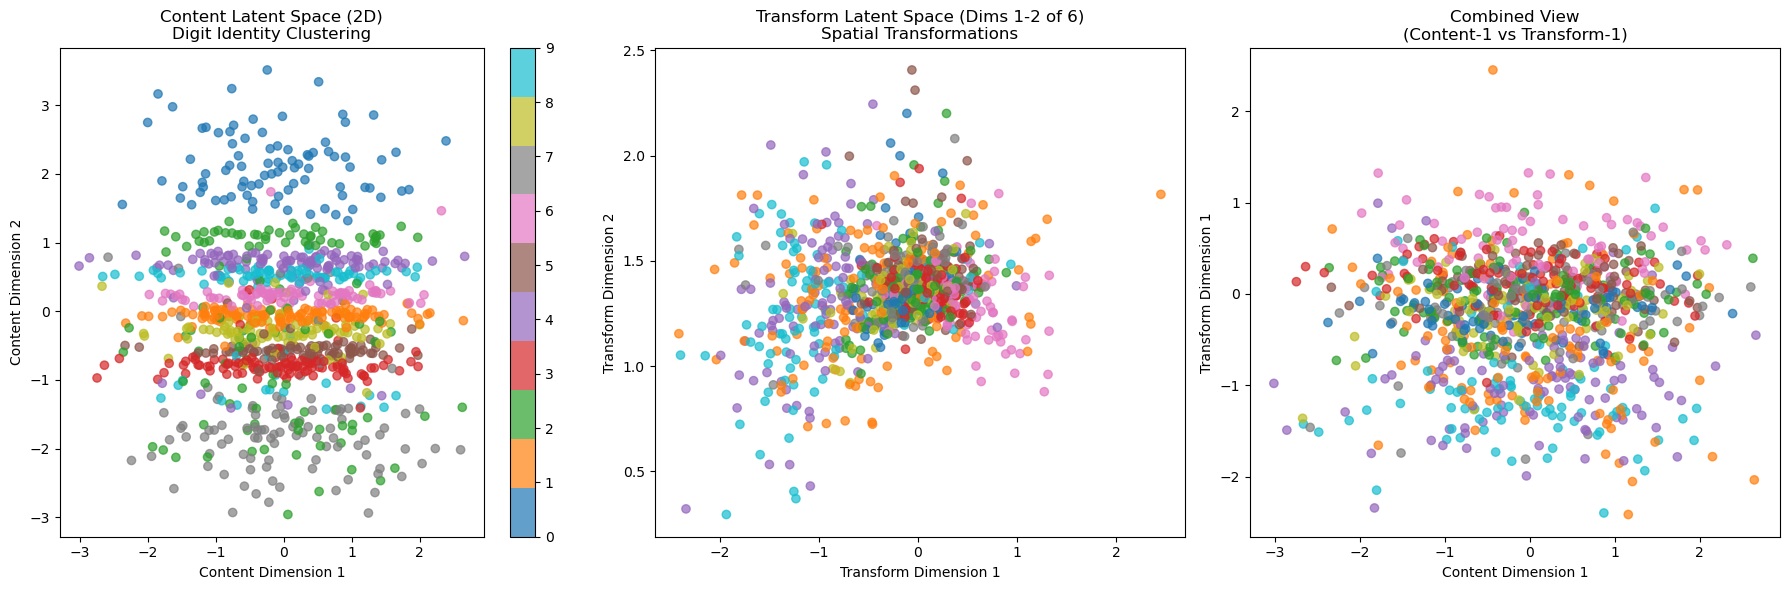

📊 Structured Latent Space Analysis:
  Content latent shape: (1000, 2)
  Transform latent shape: (1000, 6)
  Content variance: [0.9628362 1.1418201]
  Transform variance: [0.4050773  0.05047388 0.01729583 0.39345935 0.19966623 0.00645219]


In [5]:
# 📈 VISUALIZE - Using explicit module references
s2d6d.plot_simplified_training_progress_structured(losses_dict)
content_data, transform_data, label_data = s2d6d.visualize_structured_latent_space(model, test_loader, device)

/home/exouser/Documents/adversAE/adversae/vae_training/affine/structured_2d6d_autoencoder.py:341: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()


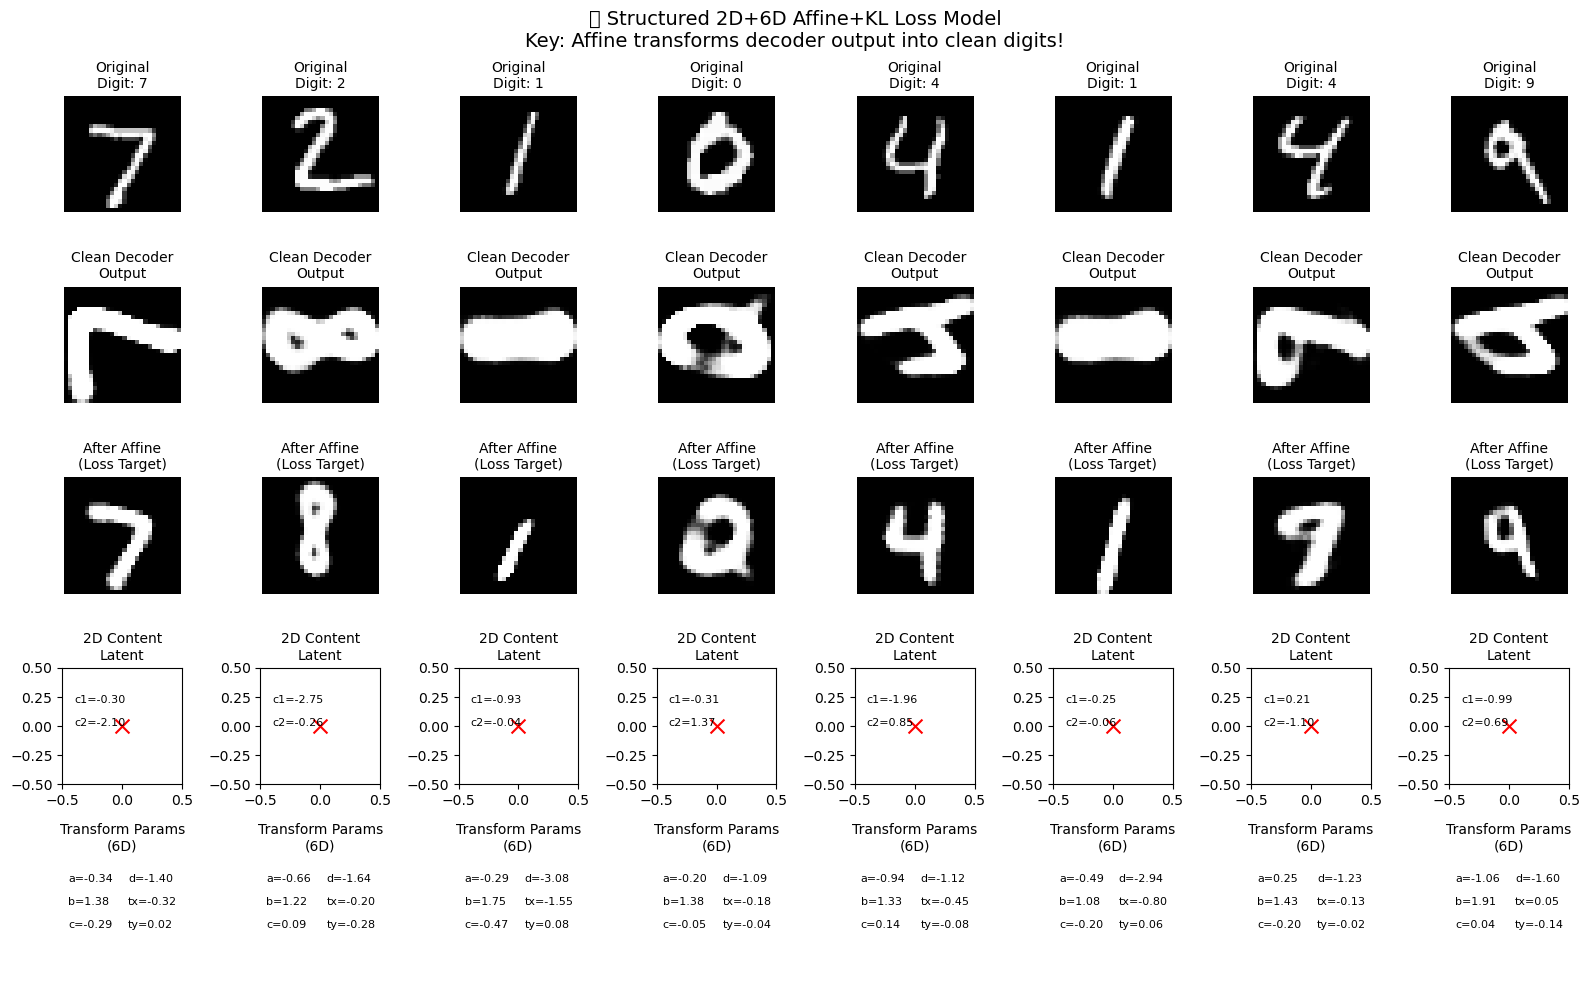


📊 Loss Analysis (Simplified Affine+KL Loss Function):
  Total Loss: 0.715033
  Reconstruction Loss (MSE after affine): 0.549078
  KL Divergence Loss (2D content latent): 16.595459
  Loss weights: α=1.0 (recon), β=0.01 (KL)

🎨 2D Content Latent Analysis:
  Content latent shape: torch.Size([8, 2])
  Content mu mean: [-0.01266048 -0.12458983]
  Content mu std: [0.00791547 1.1649816 ]
  Content logvar mean: [-4.058229e-03 -4.796918e+00]

🔧 6D Transform Latent Analysis:
  Transform latent shape: torch.Size([8, 6])
  Transform mu mean: [-0.47458342  1.416741   -0.04079187 -1.7312391  -0.40427452 -0.02339222]
  Transform logvar mean: [-2.9782975 -4.146345  -5.5835056 -4.0257726 -4.4294147 -6.4699545]

🎯 UNIFIED 8D VAE:
  Full latent mu shape: torch.Size([8, 8])
  ALL 8 dimensions under KL regularization!
  This should provide much more stable training.


In [6]:
# 🎨 COMPREHENSIVE VISUALIZATIONS - Using structured_2d6d_autoencoder module
s2d6d.comprehensive_visualization_structured(model, test_loader, device, CONFIG)

In [7]:
# 💾 SAVE - Using shared save functionality from affine_autoencoder_shared
# Basic save (model, config, losses only - no extra visualization data)
model_file, metadata_file = shared.save_model_cloud(model, CONFIG, losses_dict, device)

💾 Saved: autoencoder_model_20250722_023100.pth, autoencoder_metadata_20250722_023100.json


In [8]:
# 💾 SAVE - UNIFIED 8D VAE MODEL
# This saves everything needed to recreate visualizations later
viz_filename = shared.save_model_for_viz(
    model, 
    model_type="unified_8d_vae",  # Updated to reflect unified architecture
    config=CONFIG,
    losses=losses_dict,
    extra_data={
        'content_data': content_data,
        'transform_data': transform_data,
        'label_data': label_data,
        'config': CONFIG,
        'architecture_version': 'unified_8d_v3'  # Version flag for compatibility
    },
    name="unified_8d_vae"  # Clear name for the unified architecture
)
print(f"💾 Model saved as: {viz_filename}")
print("🎯 This model uses the UNIFIED 8D VAE architecture with:")
print("  - Balanced KL regularization on all 8 dimensions")
print("  - Should show stable training and good digit clustering!")

💾 Saved unified_8d_vae model for visualization: unified_8d_vae_unified_8d_vae_20250722_023104.pth
💾 Model saved as: unified_8d_vae_unified_8d_vae_20250722_023104.pth
🎯 This model uses the UNIFIED 8D VAE architecture with:
  - Balanced KL regularization on all 8 dimensions
  - Should show stable training and good digit clustering!


In [11]:
#📁 LOAD MODEL FOR VISUALIZATION
#Run this cell to load a previously saved model instead of training from scratch
#NOTE: Fixed for PyTorch 2.6 weights_only issue

#Option 1: Load specific model by filename
model_path = 'structured_2d6d_simplified_20250721_013420.pth'
loaded_model, viz_data = shared.load_model_for_viz(model_path, 
                                                   s2d6d.StructuredAffineInvariantAutoEncoder, device)


📁 Loaded structured model from structured_2d6d_simplified_20250721_013420.pth
   Timestamp: 20250721_013420
   Device: cuda


In [18]:
viz_data.keys()

dict_keys(['config', 'losses', 'extra_data', 'timestamp', 'model_type', 'device'])

/home/exouser/Documents/adversAE/adversae/vae_training/affine/structured_2d6d_autoencoder.py:343: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/home/exouser/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


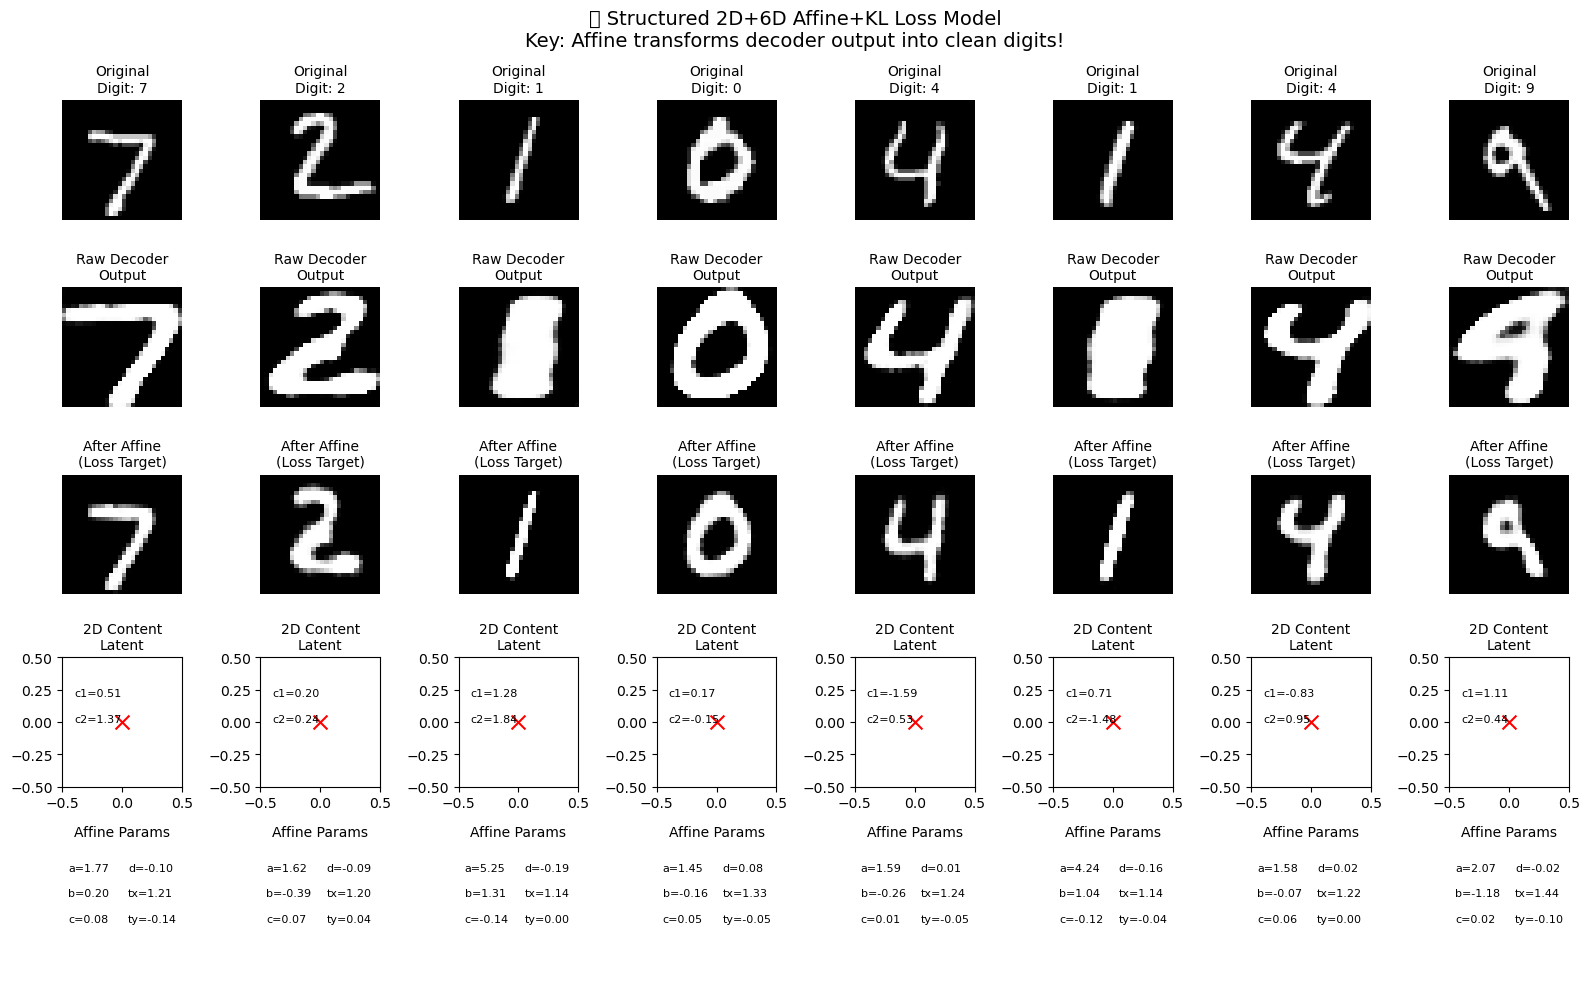


📊 Loss Analysis (Simplified Affine+KL Loss Function):
  Total Loss: 0.461004
  Reconstruction Loss (MSE after affine): 0.460158
  KL Divergence Loss (2D content latent): 0.846649
  Loss weights: α=1.0 (recon), β=0.001 (KL)

🎨 2D Content Latent Analysis:
  Content latent shape: torch.Size([8, 2])
  Content mu mean: [0.04174796 0.1323441 ]
  Content mu std: [0.674817   0.38179943]
  Content logvar mean: [-1.9465275 -0.2261337]

🔧 6D Transform Latent Analysis:
  Transform latent shape: torch.Size([8, 6])
  Transform mean: [-1.3637471  -1.4489424  -0.5418373  -2.2890437   2.6050673  -0.45559955]
  Transform std: [4.8383174 2.4993849 3.3657496 3.1386137 2.4901476 3.5223966]


In [12]:
s2d6d.comprehensive_visualization_structured(loaded_model, test_loader, device, CONFIG)

In [ ]:
# 📁 LOAD MODEL FOR VISUALIZATION
# Run this cell to load a previously saved model instead of training from scratch
# NOTE: Fixed for PyTorch 2.6 weights_only issue

# Option 1: Load specific model by filename
# model_path = '/path/to/your/structured_2d6d_simplified_20250720_123456.pth'
# loaded_model, viz_data = shared.load_model_for_viz(model_path, 
#                                                    s2d6d.StructuredAffineInvariantAutoEncoder, device)

# Option 2: Quick load most recent model
# loaded_model, viz_data = shared.quick_load_viz(s2d6d.StructuredAffineInvariantAutoEncoder, 
#                                                model_type="structured", name="2d6d_simplified", device=device)

# After loading, you can access:
# - loaded_model: The trained model ready for inference
# - viz_data['config']: Original training configuration  
# - viz_data['losses']: Training loss history
# - viz_data['extra_data']: Latent embeddings and other visualization data

# If you loaded a model, uncomment these lines to use it:
# model = loaded_model
# CONFIG = viz_data['config']
# losses_dict = viz_data['losses']
# if 'extra_data' in viz_data:
#     content_data = viz_data['extra_data'].get('content_data')
#     transform_data = viz_data['extra_data'].get('transform_data')
#     label_data = viz_data['extra_data'].get('label_data')

print("💡 Uncomment the lines above to load a saved model for visualization")